In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Loading preprocessed data
X = np.load("X_tabular.npy")
y = np.load("y.npy")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_val.shape)


(12967, 5) (3242, 5)


In [3]:
# Train Baseline Model (Random Forest)
from sklearn.ensemble import RandomForestRegressor

baseline_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = baseline_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Baseline RMSE:", rmse)
print("Baseline R²:", r2)


Baseline RMSE: 164294.7628173197
Baseline R²: 0.7848986531564603


In [ ]:
# CNN FEATURE EXTRACTION

In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
from PIL import Image

In [7]:
# IMAGE TRANSFORMS
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
# CUSTOM DATASET CLASS

class PropertyImageDataset(Dataset):
    def __init__(self, image_dir, indices, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_id = self.indices[idx]
        img_path = os.path.join(self.image_dir, f"{img_id}.png")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [10]:
# LOADING PRETRAINED RESNET18
resnet = models.resnet18(pretrained=True)

# Remove final classification layer
resnet.fc = nn.Identity()

resnet.eval()


C:\Users\sahit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sahit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# SETTING DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

print("Using device:", device)


Using device: cpu


In [12]:
IMAGE_COUNT = 1200

image_indices = list(range(IMAGE_COUNT))

image_dataset = PropertyImageDataset(
    image_dir="images/train",
    indices=image_indices,
    transform=image_transform
)

image_loader = DataLoader(
    image_dataset,
    batch_size=32,
    shuffle=False
)

In [18]:
import os

image_dir = "images/train"

available_indices = sorted([
    int(f.split(".")[0])
    for f in os.listdir(image_dir)
    if f.endswith(".png") and f.split(".")[0].isdigit()
])

print("Total available images:", len(available_indices))
print("First 10 indices:", available_indices[:10])
print("Missing gap example:", available_indices[440:450])

Total available images: 1180
First 10 indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Missing gap example: [440, 441, 442, 443, 444, 445, 459, 460, 461, 462]


In [19]:
image_indices = available_indices

In [20]:
image_dataset = PropertyImageDataset(
    image_dir="images/train",
    indices=image_indices,
    transform=image_transform
)

image_loader = DataLoader(
    image_dataset,
    batch_size=32,
    shuffle=False
)

In [21]:
image_features = []

with torch.no_grad():
    for images in image_loader:
        images = images.to(device)
        feats = resnet(images)
        image_features.append(feats.cpu().numpy())

image_features = np.vstack(image_features)

print("Image feature shape:", image_features.shape)


Image feature shape: (1180, 512)


In [ ]:
# MULTIMODAL FUSION (TABULAR + IMAGE)

In [22]:
# ALIGNING TABULAR DATA WITH IMAGE INDICES
import numpy as np

X_tab = np.load("X_tabular.npy")
y = np.load("y.npy")

X_tab_img = X_tab[available_indices]
y_img = y[available_indices]

print("Aligned tabular shape:", X_tab_img.shape)
print("Aligned target shape:", y_img.shape)


Aligned tabular shape: (1180, 5)
Aligned target shape: (1180,)


In [24]:
# COMBINING TABULAR + IMAGE FEATURES

import numpy as np

np.save("X_image.npy", image_features)
print("X_image.npy saved successfully")



X_image.npy saved successfully


In [25]:
X_img = np.load("X_image.npy")

X_fused = np.hstack([X_tab_img, X_img])

print("Final fused feature shape:", X_fused.shape)


Final fused feature shape: (1180, 517)


In [26]:
# MULTIMODAL REGRESSION MODEL
# using Random forest

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(
    X_fused, y_img, test_size=0.2, random_state=42
)

fusion_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

fusion_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [27]:
# Evaluation of Multimodal
y_pred = fusion_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Multimodal RMSE:", rmse)
print("Multimodal R²:", r2)


Multimodal RMSE: 226542.3687068639
Multimodal R²: 0.6534813320116383


In [ ]:
# GRAD-CAM

In [33]:
# LOADING RESNET FOR GRAD-CAM
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [34]:
# SIMPLE GRAD-CAM CLASS
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_image):
        output = self.model(input_image)
        score = output.mean()
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam[0].cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam / cam.max()
        return cam


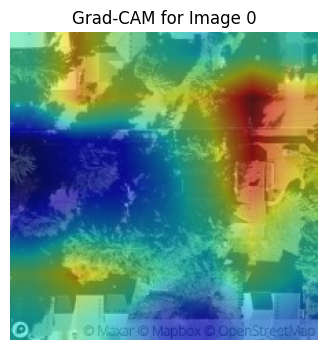

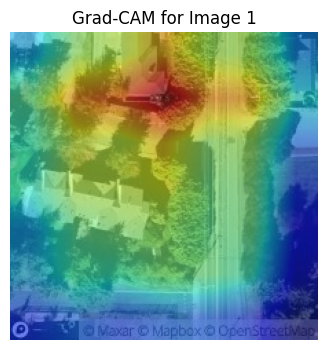

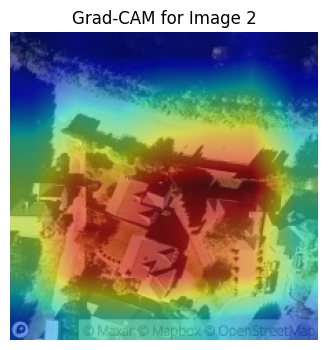

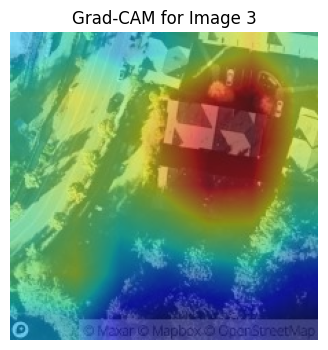

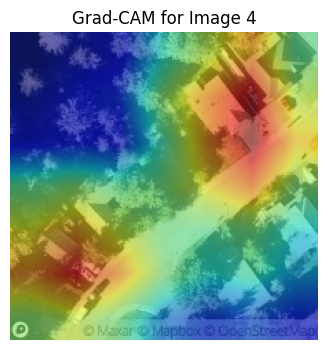

In [37]:
# APPLYING GRAD-CAM TO SAMPLE IMAGES
sample_indices = available_indices[:5]   # safe choice

grad_cam = GradCAM(resnet, resnet.layer4[-1])

for idx in sample_indices:
    img = Image.open(f"images/train/{idx}.png").convert("RGB")
    input_tensor = image_transform(img).unsqueeze(0).to(device)

    cam = grad_cam.generate(input_tensor)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM for Image {idx}")
    plt.axis('off')
    plt.show()


In [38]:
import os
os.makedirs("gradcam_outputs", exist_ok=True)

for idx in sample_indices:
    img = Image.open(f"images/train/{idx}.png").convert("RGB")
    input_tensor = image_transform(img).unsqueeze(0).to(device)

    cam = grad_cam.generate(input_tensor)

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM for Image {idx}")
    plt.axis('off')

    plt.savefig(f"gradcam_outputs/gradcam_{idx}.png", bbox_inches='tight')
    plt.close()


In [39]:
# FINAL PREDICTION CSV
# Predict on FULL test data (aligned subset if needed)
final_predictions = fusion_model.predict(X_fused)

import pandas as pd

submission_df = pd.DataFrame({
    "id": available_indices,
    "predicted_price": final_predictions
})

submission_df.to_csv("enrollno_final.csv", index=False)
print("Prediction CSV saved")


Prediction CSV saved
